In [31]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, classification_report

In [32]:
# Cargar todos los datasets
X_train_normal = np.load("./trains/X_train_scaled.npy")
X_train_smote = np.load('./trains/X_train_smote.npy')
X_train_smoteenn = np.load('./trains/X_train_smoteenn.npy')
X_test = np.load("./trains/X_test_scaled.npy")

y_train_normal = np.load("./trains/y_train.npy")
y_train_smote = np.load('./trains/y_train_smote.npy')
y_train_smoteenn = np.load('./trains/y_train_smoteenn.npy')
y_test = np.load("./trains/y_test.npy")

print(f"Normal dataset: {X_train_normal.shape}, Fraud ratio: {y_train_normal.mean():.4f}")
print(f"SMOTE dataset: {X_train_smote.shape}, Fraud ratio: {y_train_smote.mean():.4f}")
print(f"SMOTEENN dataset: {X_train_smoteenn.shape}, Fraud ratio: {y_train_smoteenn.mean():.4f}")
print(f"Test dataset: {X_test.shape}, Fraud ratio: {y_test.mean():.4f}")

Normal dataset: (758328, 48), Fraud ratio: 0.0110
SMOTE dataset: (974935, 48), Fraud ratio: 0.2308
SMOTEENN dataset: (917419, 48), Fraud ratio: 0.2451
Test dataset: (241672, 48), Fraud ratio: 0.0110


In [33]:
# Crear tensores para los 3 datasets
datasets = {
    'normal': {
        'X_train': torch.tensor(X_train_normal, dtype=torch.float32),
        'y_train': torch.tensor(y_train_normal, dtype=torch.float32),
        'train_loader': None
    },
    'smote': {
        'X_train': torch.tensor(X_train_smote, dtype=torch.float32),
        'y_train': torch.tensor(y_train_smote, dtype=torch.float32),
        'train_loader': None
    },
    'smoteenn': {
        'X_train': torch.tensor(X_train_smoteenn, dtype=torch.float32),
        'y_train': torch.tensor(y_train_smoteenn, dtype=torch.float32),
        'train_loader': None
    }
}

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Crear DataLoaders
for name, data in datasets.items():
    train_dataset = TensorDataset(data['X_train'], data['y_train'])
    data['train_loader'] = DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [34]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        pt = torch.exp(-BCE_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

In [35]:
class MLP(nn.Module):
  def __init__(self, input_dim):
    super(MLP, self).__init__()
    self.net = nn.Sequential( #? Added
      nn.Linear(input_dim, 256),
      nn.ReLU(),
      nn.BatchNorm1d(256),
      nn.Dropout(0.3),

      nn.Linear(256, 128),
      nn.ReLU(),
      nn.BatchNorm1d(128),
      nn.Dropout(0.3),

      nn.Linear(128, 64),
      nn.ReLU(),
      nn.BatchNorm1d(64),
      nn.Dropout(0.3),

      nn.Linear(64, 1)
    )
  def forward(self, x):
    return self.net(x).squeeze(1)

In [36]:
def train_model(model, loss_fn, optimizer, train_loader, n_epochs=20, patience=7):
    model.train()
    best_loss = float('inf')
    wait = 0
    history = []
    for epoch in range(n_epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        history.append(avg_loss)
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {avg_loss:.4f}")

        if avg_loss < best_loss - 1e-4:
            best_loss = avg_loss
        else:
            wait += 1
            if wait >= patience:
                print('Early stopping')
                break
    return history

In [37]:
def evaluate_model(model, X_test_tensor, y_test, name="Model"):
    model.eval()
    with torch.no_grad():
        y_pred_logits = model(X_test_tensor)
        y_pred = torch.sigmoid(y_pred_logits).numpy()
        precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)
        f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
        best_hreshold = thresholds[np.argmax(f1s)]
        threshold = best_hreshold
        y_pred_labels = (y_pred >= threshold).astype(int)

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred_labels, digits=4))
    print("AUC:", roc_auc_score(y_test, y_pred))
    print("F1:", f1_score(y_test, y_pred_labels))
    print("Precision:", precision_score(y_test, y_pred_labels))
    print("Recall:", recall_score(y_test, y_pred_labels))
    
    return y_pred, y_pred_labels

In [38]:
# Entrenar los 3 modelos
models = {}
histories = {}
predictions = {}

input_dim = X_train_normal.shape[1]

print("=" * 60)
print("ENTRENANDO MODELOS MLP")
print("=" * 60)

for name, data in datasets.items():
    print(f"\n--- Entrenando modelo {name.upper()} ---")
    
    # Crear modelo
    model = MLP(input_dim)
    loss_fn = FocalLoss(alpha=0.25, gamma=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # Entrenar
    history = train_model(model, loss_fn, optimizer, data['train_loader'], n_epochs=20)
    
    # Evaluar
    y_pred, y_pred_labels = evaluate_model(model, X_test_tensor, y_test, f"MLP - {name.title()}")
    
    # Guardar resultados
    models[name] = model
    histories[name] = history
    predictions[name] = {
        'y_pred': y_pred,
        'y_pred_labels': y_pred_labels
    }
    
    # Guardar modelo
    os.makedirs("./models", exist_ok=True)
    torch.save(model.state_dict(), f"./models/mlp_{name}.pth")

ENTRENANDO MODELOS MLP

--- Entrenando modelo NORMAL ---
Epoch 1/20 - Loss: 0.0073
Epoch 2/20 - Loss: 0.0038
Epoch 3/20 - Loss: 0.0037
Epoch 4/20 - Loss: 0.0037
Epoch 5/20 - Loss: 0.0036
Epoch 6/20 - Loss: 0.0036
Epoch 7/20 - Loss: 0.0035
Epoch 8/20 - Loss: 0.0035
Epoch 9/20 - Loss: 0.0035
Epoch 10/20 - Loss: 0.0035
Epoch 11/20 - Loss: 0.0035
Epoch 12/20 - Loss: 0.0034
Early stopping

=== MLP - Normal ===
              precision    recall  f1-score   support

           0     0.9917    0.9867    0.9892    239020
           1     0.1767    0.2568    0.2093      2652

    accuracy                         0.9787    241672
   macro avg     0.5842    0.6218    0.5993    241672
weighted avg     0.9828    0.9787    0.9807    241672

AUC: 0.8708962150058945
F1: 0.20934521979711035
Precision: 0.17669953295277632
Recall: 0.25678733031674206

--- Entrenando modelo SMOTE ---
Epoch 1/20 - Loss: 0.0206
Epoch 2/20 - Loss: 0.0171
Epoch 3/20 - Loss: 0.0155
Epoch 4/20 - Loss: 0.0145
Epoch 5/20 - Loss: 0

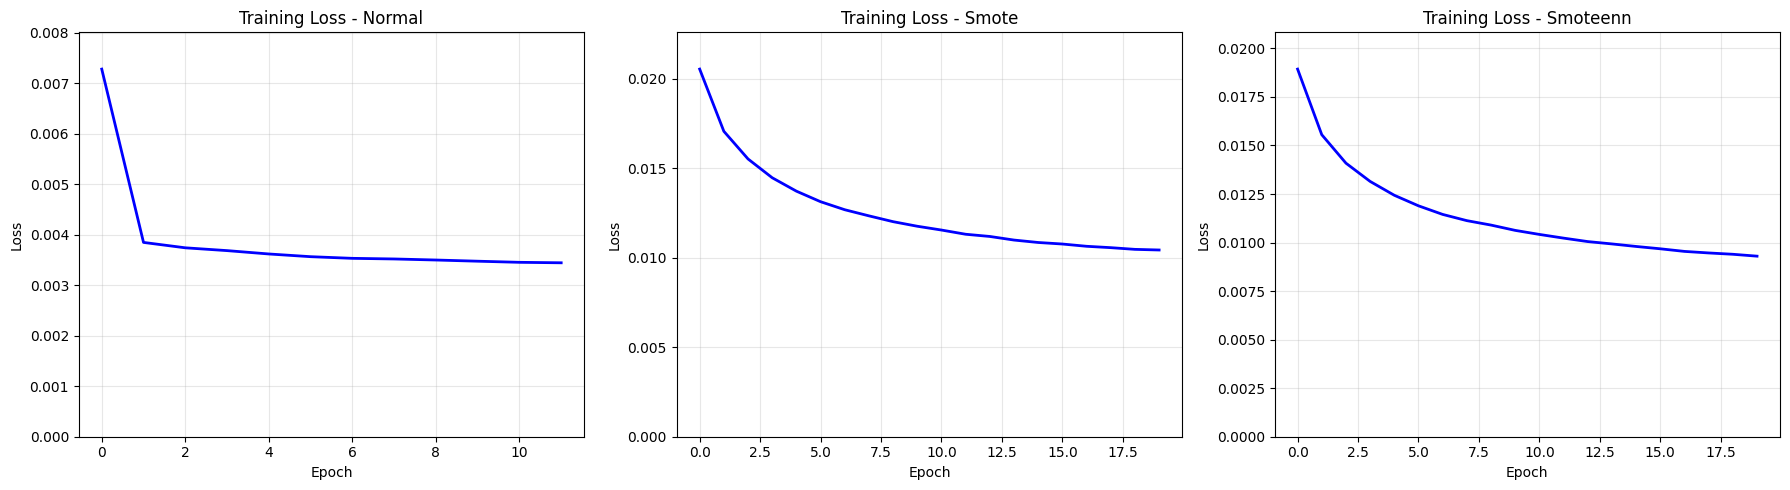

In [39]:
# Crear directorio para plots
os.makedirs("./plots/mlp", exist_ok=True)

# 1. Gráficos individuales de pérdida
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, history) in enumerate(histories.items()):
    axes[i].plot(history, 'b-', linewidth=2)
    axes[i].set_title(f'Training Loss - {name.title()}')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Loss')
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim(0, max(history) * 1.1)

plt.tight_layout()
plt.savefig('./plots/mlp/individual_training_losses.png', dpi=300, bbox_inches='tight')
plt.show()

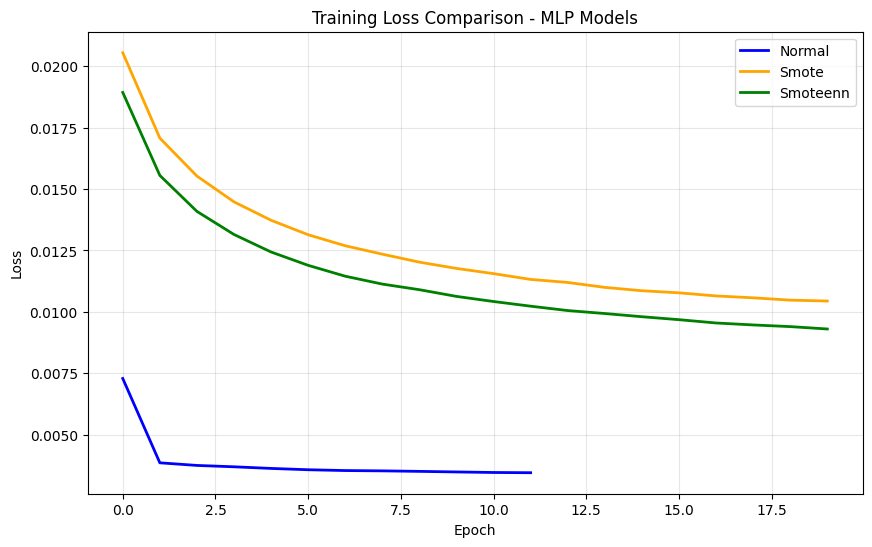

In [40]:
# 2. Comparación de pérdidas en un solo gráfico
plt.figure(figsize=(10, 6))

colors = ['blue', 'orange', 'green']
for i, (name, history) in enumerate(histories.items()):
    plt.plot(history, color=colors[i], label=f'{name.title()}', linewidth=2)

plt.title('Training Loss Comparison - MLP Models')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('./plots/mlp/training_loss_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

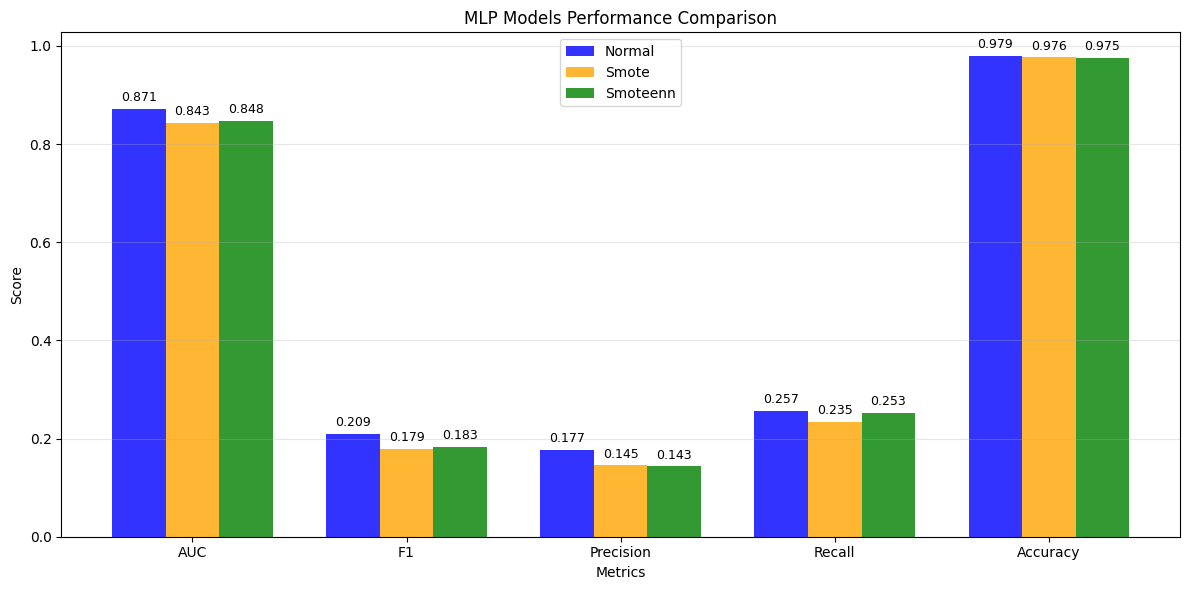

In [41]:
# 3. Métricas comparativas en barras
from sklearn.metrics import accuracy_score

metrics_data = {}
for name, pred_data in predictions.items():
    y_pred = pred_data['y_pred']
    y_pred_labels = pred_data['y_pred_labels']
    
    metrics_data[name] = {
        'AUC': roc_auc_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred_labels),
        'Precision': precision_score(y_test, y_pred_labels),
        'Recall': recall_score(y_test, y_pred_labels),
        'Accuracy': accuracy_score(y_test, y_pred_labels)
    }

# Gráfico de métricas
metrics = ['AUC', 'F1', 'Precision', 'Recall', 'Accuracy']
x_pos = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))

for i, (name, data) in enumerate(metrics_data.items()):
    values = [data[metric] for metric in metrics]
    ax.bar(x_pos + i * width, values, width, label=name.title(), color=colors[i], alpha=0.8)

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('MLP Models Performance Comparison')
ax.set_xticks(x_pos + width)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for i, (name, data) in enumerate(metrics_data.items()):
    values = [data[metric] for metric in metrics]
    for j, v in enumerate(values):
        ax.text(j + i * width, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('./plots/mlp/metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

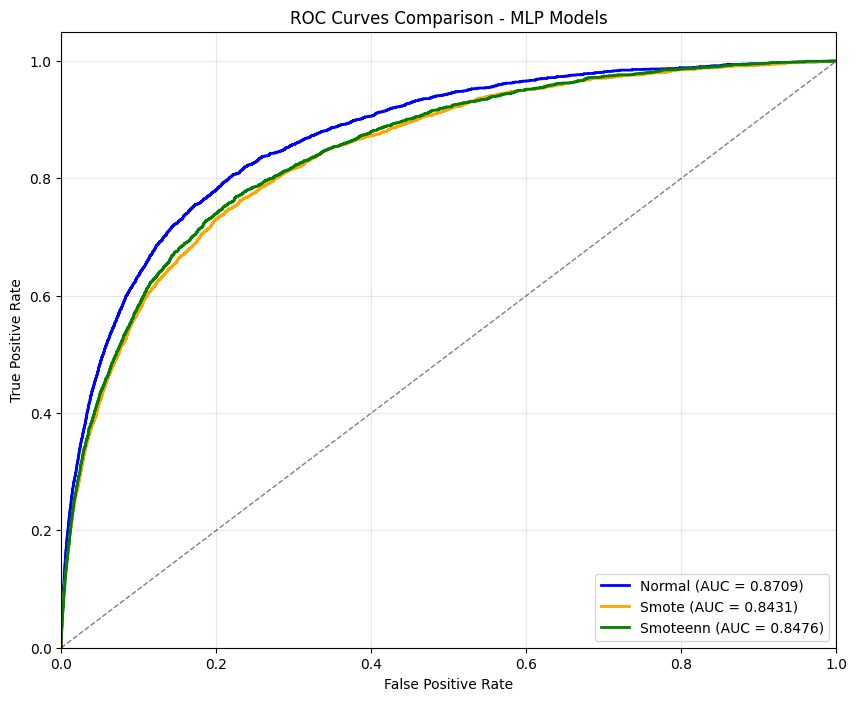

In [42]:
# 4. ROC Curves Comparison
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 8))

for i, (name, pred_data) in enumerate(predictions.items()):
    fpr, tpr, _ = roc_curve(y_test, pred_data['y_pred'])
    auc_score = roc_auc_score(y_test, pred_data['y_pred'])
    plt.plot(fpr, tpr, color=colors[i], linewidth=2, 
             label=f'{name.title()} (AUC = {auc_score:.4f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison - MLP Models')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('./plots/mlp/roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

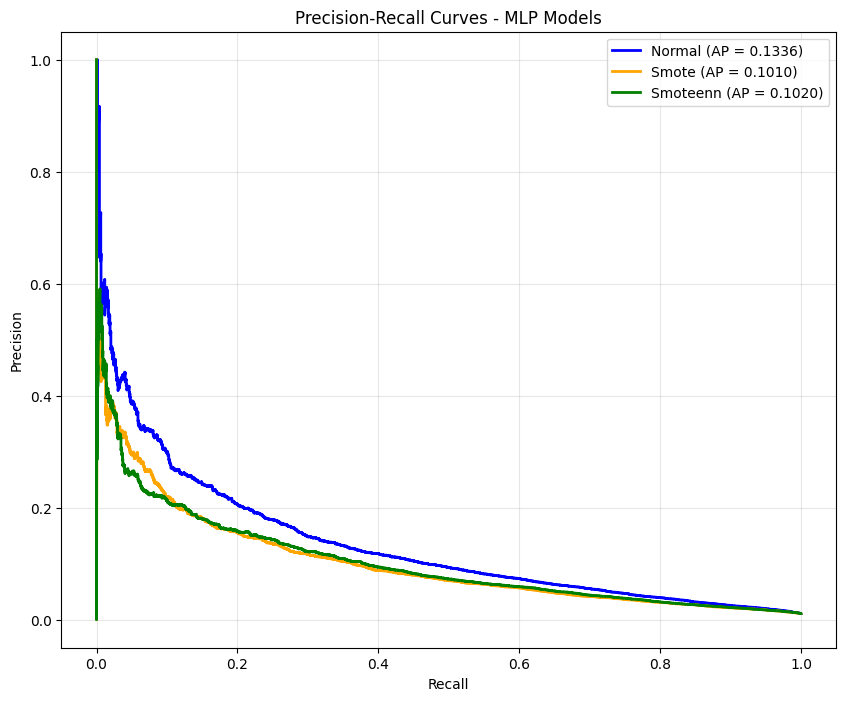

In [43]:
# 5. Precision-Recall Curves
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 8))

for i, (name, pred_data) in enumerate(predictions.items()):
    precision, recall, _ = precision_recall_curve(y_test, pred_data['y_pred'])
    ap_score = average_precision_score(y_test, pred_data['y_pred'])
    plt.plot(recall, precision, color=colors[i], linewidth=2,
             label=f'{name.title()} (AP = {ap_score:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves - MLP Models')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('./plots/mlp/precision_recall_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

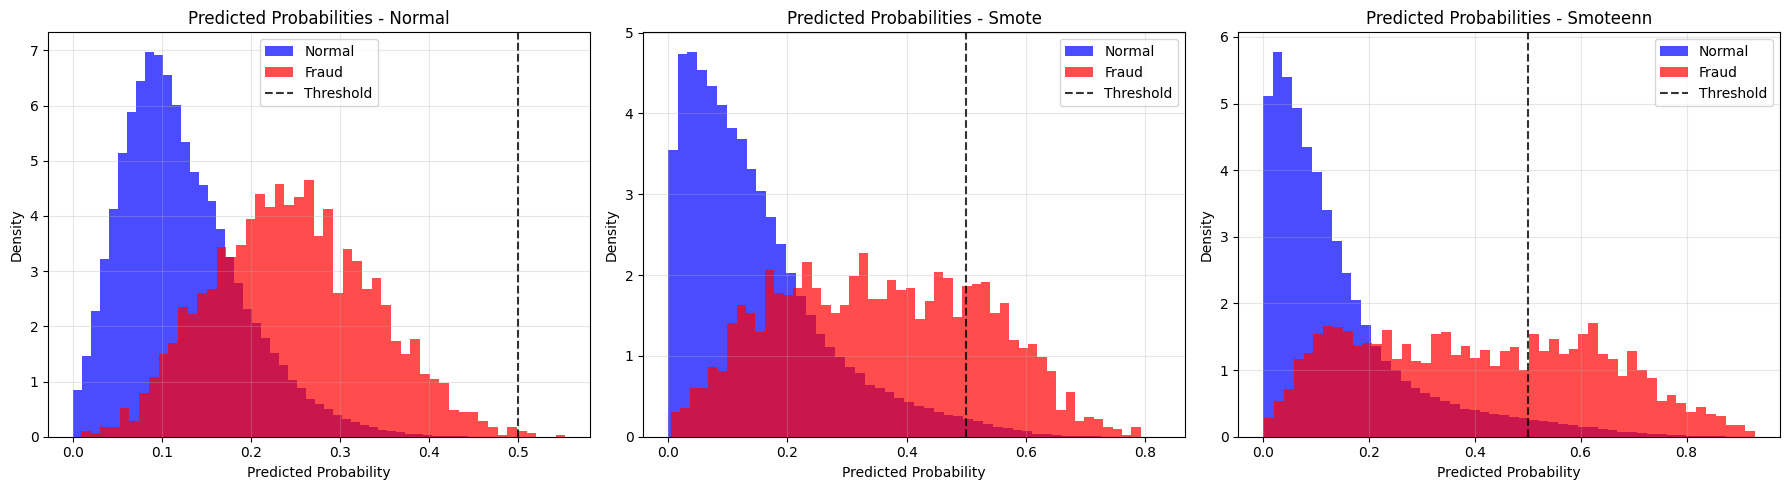

In [44]:
# 6. Distribución de probabilidades predichas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, pred_data) in enumerate(predictions.items()):
    y_pred = pred_data['y_pred']
    
    # Separar por clase real
    fraud_probs = y_pred[y_test == 1]
    normal_probs = y_pred[y_test == 0]
    
    axes[i].hist(normal_probs, bins=50, alpha=0.7, label='Normal', color='blue', density=True)
    axes[i].hist(fraud_probs, bins=50, alpha=0.7, label='Fraud', color='red', density=True)
    axes[i].axvline(x=0.5, color='black', linestyle='--', alpha=0.8, label='Threshold')
    axes[i].set_title(f'Predicted Probabilities - {name.title()}')
    axes[i].set_xlabel('Predicted Probability')
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./plots/mlp/probability_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

In [45]:
# 7. Resumen final de resultados
print("\n" + "="*80)
print("RESUMEN FINAL - MODELOS MLP")
print("="*80)

print(f"{'Metric':<12} {'Normal':<10} {'SMOTE':<10} {'SMOTEENN':<10}")
print("-" * 50)

for metric in metrics:
    row = f"{metric:<12}"
    for name in ['normal', 'smote', 'smoteenn']:
        value = metrics_data[name][metric]
        row += f" {value:<9.4f}"
    print(row)

print("\nModelos guardados en:")
for name in datasets.keys():
    print(f"  - ./models/mlp_{name}.pth")

print("\nGráficos guardados en ./plots/mlp/:")
print("  - individual_training_losses.png")
print("  - training_loss_comparison.png") 
print("  - metrics_comparison.png")
print("  - roc_curves_comparison.png")
print("  - precision_recall_comparison.png")
print("  - probability_distributions.png")


RESUMEN FINAL - MODELOS MLP
Metric       Normal     SMOTE      SMOTEENN  
--------------------------------------------------
AUC          0.8709    0.8431    0.8476   
F1           0.2093    0.1793    0.1828   
Precision    0.1767    0.1451    0.1433   
Recall       0.2568    0.2345    0.2526   
Accuracy     0.9787    0.9764    0.9752   

Modelos guardados en:
  - ./models/mlp_normal.pth
  - ./models/mlp_smote.pth
  - ./models/mlp_smoteenn.pth

Gráficos guardados en ./plots/mlp/:
  - individual_training_losses.png
  - training_loss_comparison.png
  - metrics_comparison.png
  - roc_curves_comparison.png
  - precision_recall_comparison.png
  - probability_distributions.png
